In [38]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
#from generator import DataGenerator
import keras

from skimage.util import montage as montage2d
from skimage.io import imread

In [39]:
data = pd.read_csv(r'C:\Users\mikha\Desktop\Python IA RaioX\Data_Entry_2017_v2020.csv')
data1 = pd.read_csv('Data_Entry_2017_v2020.csv')
data2 = pd.read_csv('Data_Entry_2017_v2020.csv')
data3 = pd.read_csv(r'C:\Users\mikha\Desktop\Python IA RaioX\Data_Entry_2017_v2020.csv')
data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [40]:
data1 = data1[data1['Patient Age']<100] 
data_image_paths = {os.path.basename(x): x for x in
                   glob(os.path.join('images*', '*', '*.png'))}
print('Scans found:', len(data_image_paths), ', Total Headers', data1.shape[0])
data1['path'] = data1['Image Index'].map(data_image_paths.get)
data1['Patient Age'] = data1['Patient Age'].map(lambda x: int(x))

Scans found: 112120 , Total Headers 112120


In [41]:
data3 = data3[data3['Patient Age']<100] 
data_image_paths = {os.path.basename(x): x for x in
                   glob(os.path.join('images*', '*', '*.png'))}
print('Scans found:', len(data_image_paths), ', Total Headers', data3.shape[0])
data3['path'] = data3['Image Index'].map(data_image_paths.get)
data3['Patient Age'] = data3['Patient Age'].map(lambda x: int(x))

Scans found: 112120 , Total Headers 112120


In [42]:
data = data[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]

pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']

for pathology in pathology_list :
    data[pathology] = data['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

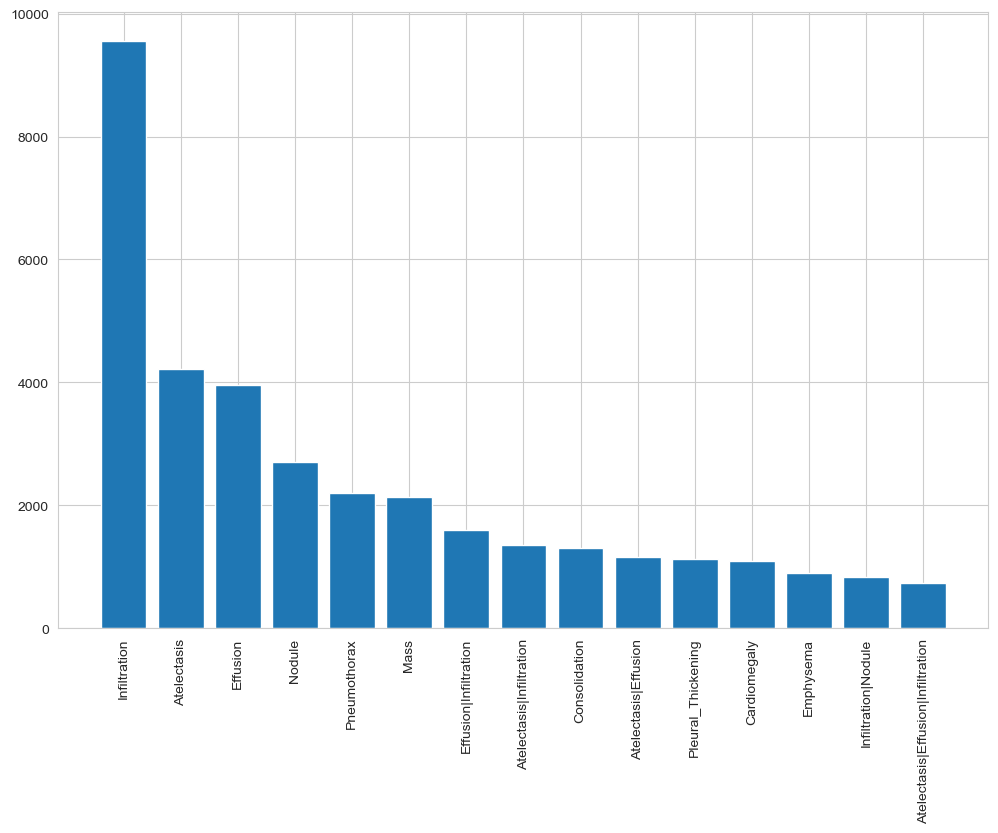

In [43]:
data2['Finding Labels'] = data2['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

non_empty_labels = data2[data2['Finding Labels'] != '']

label_counts = non_empty_labels['Finding Labels'].value_counts()[:15]

fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))
ax1.bar(np.arange(len(label_counts)) + 0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts)) + 0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation=90)

In [44]:
data1['Finding Labels'] = data1['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*data1['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        data1[c_label] = data1['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
data1.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
88012,00021772_009.png,Effusion|Nodule,9,21772,62,M,PA,2990,2991,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
49763,00012625_005.png,,5,12625,22,F,PA,2530,2829,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46640,00011911_000.png,,0,11911,70,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
data3['Finding Labels'] = data3['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*data3['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        data3[c_label] = data3['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
data3.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
55571,00013917_008.png,Mass,7,13917,53,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3398,00000902_003.png,Atelectasis|Infiltration,0,902,53,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
70188,00017277_001.png,,1,17277,51,F,PA,2758,2193,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if data1[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(data1[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


In [47]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if data3[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(data3[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


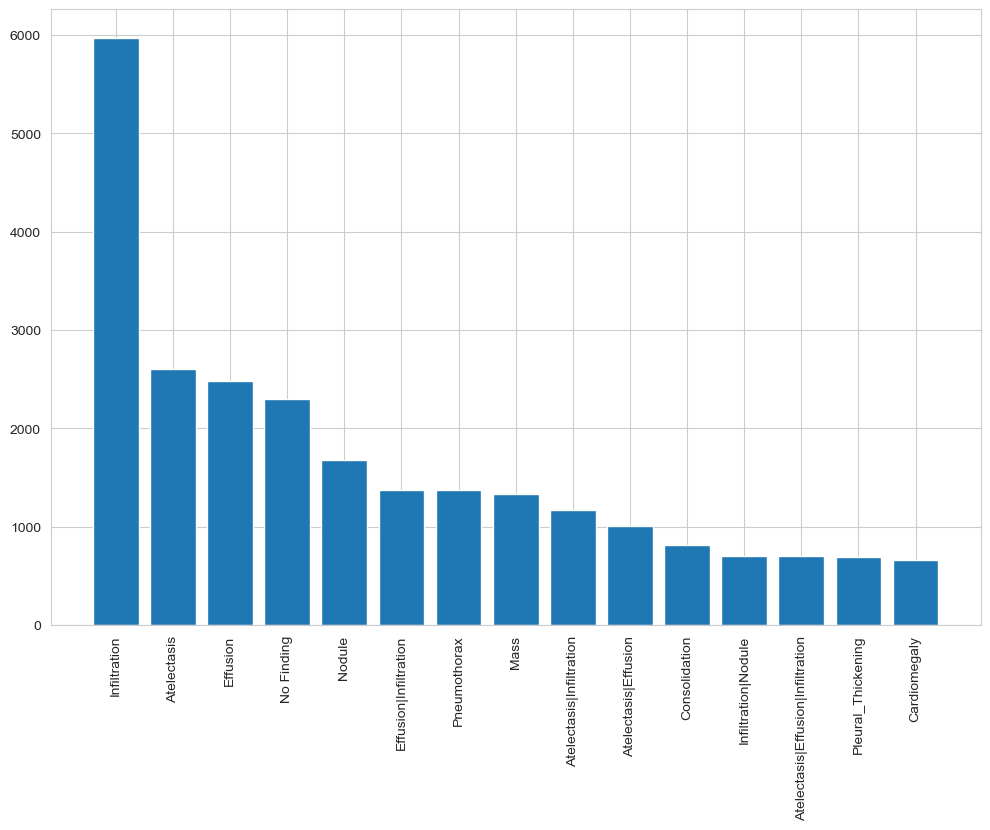

In [48]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.04 + number of findings
sample_weights = data1['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
data1 = data.sample(40000, weights=sample_weights)

label_counts = data1['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [49]:
# creating vector of diseases
data1['disease_vec'] = data1.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [50]:
# creating vector of diseases
data3['disease_vec'] = data3.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [51]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data3, 
                                   test_size = 0.20, 
                                   random_state = 2018,
                                   stratify = data['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'test', test_df.shape[0])

train 89696 test 22424


In [52]:
train_df, valid_df = train_test_split(train_df, 
                                   test_size = 0.10, 
                                   random_state = 2018,
                                   stratify = train_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'valid', valid_df.shape[0])

train 80726 valid 8970


In [53]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [54]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [55]:
# train_gen = flow_from_dataframe(core_idg, train_df, 
#                              path_col = 'path',
#                             y_col = 'disease_vec', 
#                             target_size = IMG_SIZE,
#                              color_mode = 'grayscale',
#                             batch_size = 32)

# valid_gen = flow_from_dataframe(core_idg, valid_df, 
#                              path_col = 'path',
#                             y_col = 'disease_vec', 
#                             target_size = IMG_SIZE,
#                              color_mode = 'grayscale',
#                             batch_size = 256) # we can use much larger batches for evaluation
# # used a fixed dataset for evaluating the algorithm
# test_X, test_Y = next(flow_from_dataframe(
#                             core_idg,test_df,
#                             path_col='path',
#                             y_col='disease_vec',
#                             target_size=IMG_SIZE,
#                             color_mode='grayscale',
#                             batch_size=1024)) # one big batch

In [56]:
from keras.applications.densenet import DenseNet121, preprocess_input

In [57]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

IndexError: list index out of range

In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 1, 
                                  callbacks = callbacks_list)

In [ ]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

In [ ]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

In [ ]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch = 100,
                                  validation_data =  (test_X, test_Y), 
                                  epochs = 5, 
                                  callbacks = callbacks_list)

In [ ]:
# load the best weights
multi_disease_model.load_weights(weight_path)

In [ ]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

In [ ]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

In [ ]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')

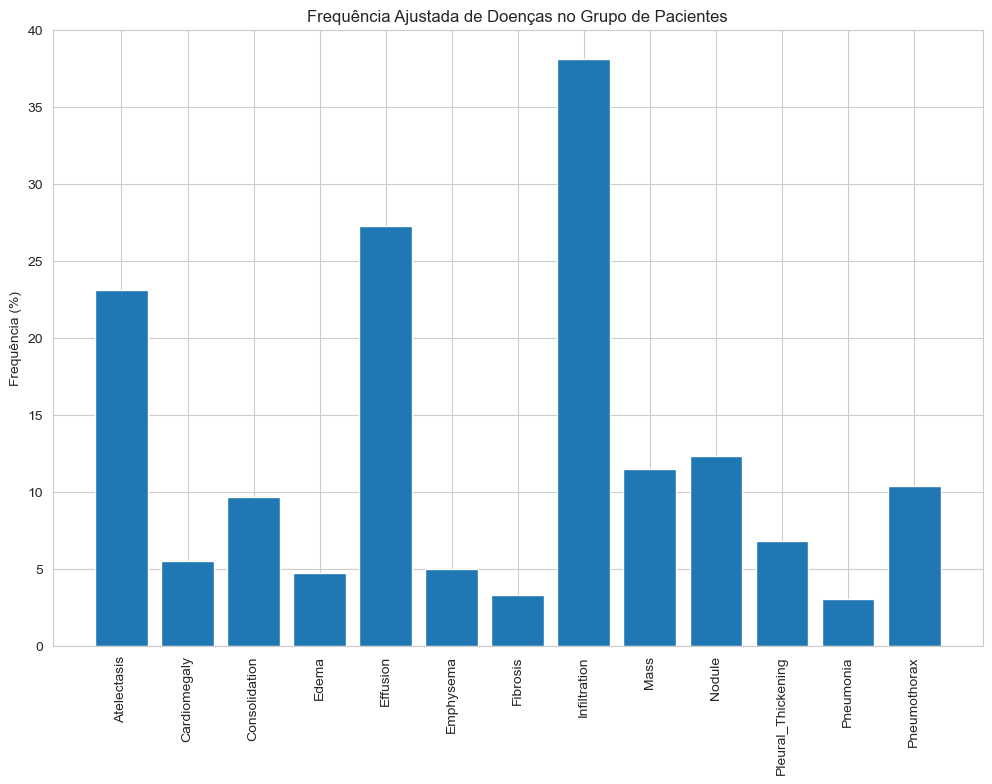

In [59]:
label_counts = 100*np.mean(data1[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Frequência Ajustada de Doenças no Grupo de Pacientes')
_ = ax1.set_ylabel('Frequência (%)')

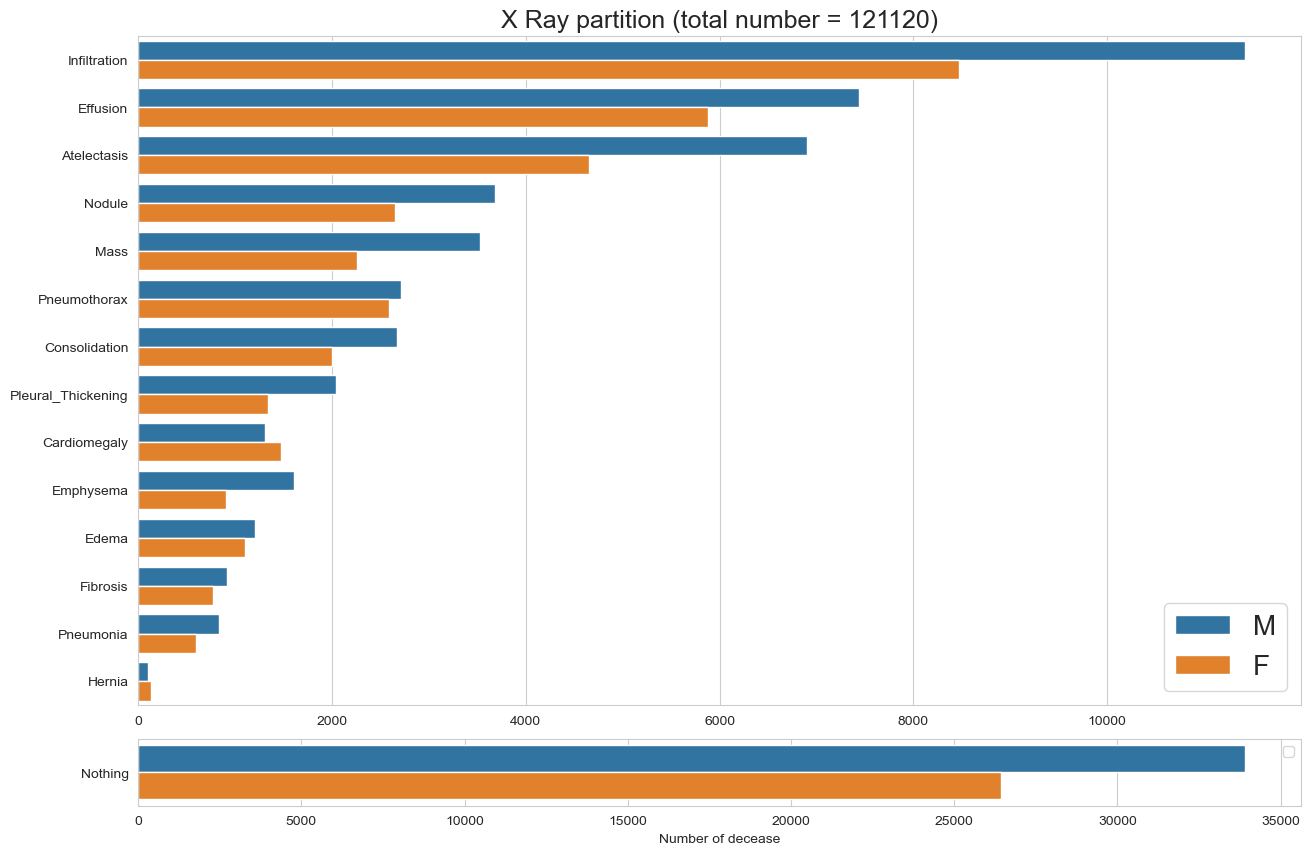

In [60]:
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(data,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition (total number = 121120)',fontsize=18);

data['Nothing']=data['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(data,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of decease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)

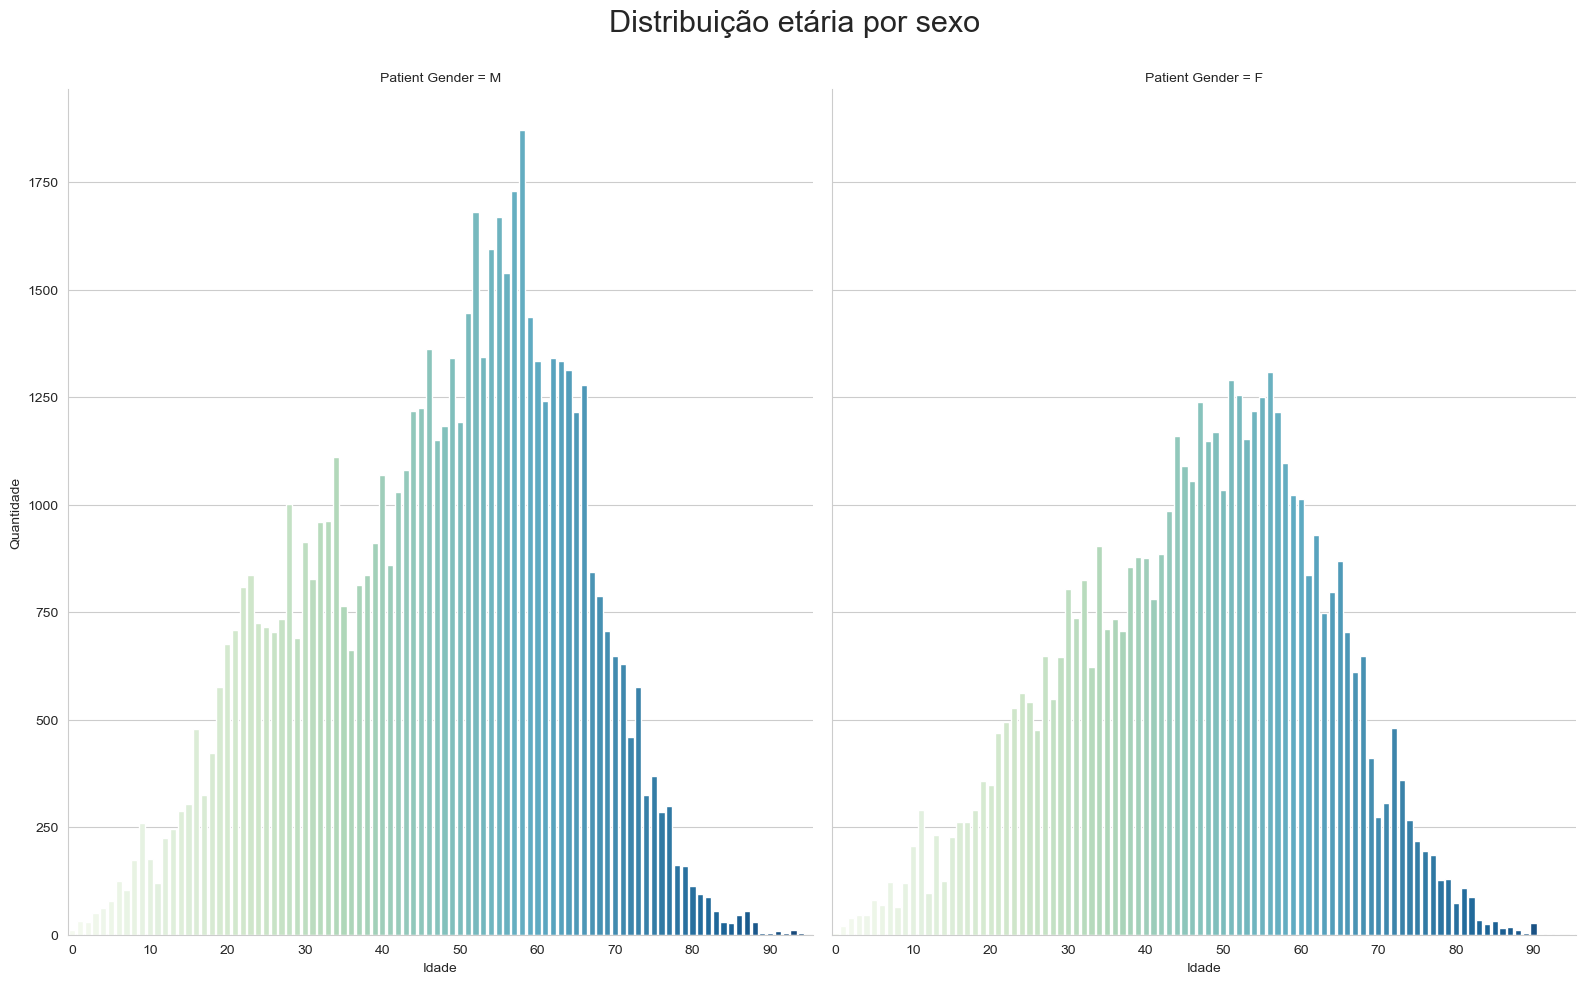

In [61]:
# Cria o gráfico
g = sns.catplot(x="Patient Age", col="Patient Gender", data=data, kind="count", height=10, aspect=0.8, palette="GnBu")

# Ajusta os ticks e rótulos nos eixos x de cada subplot
for ax in g.axes.flat:
    ax.set_xticks(np.arange(0, 100, 10))
    ax.set_xticklabels(np.arange(0, 100, 10))

# Define rótulos globais
g.set_axis_labels("Idade", "Quantidade")
g.fig.suptitle('Distribuição etária por sexo', fontsize=22)
g.fig.subplots_adjust(top=.9)

# Mostra o gráfico
plt.show()

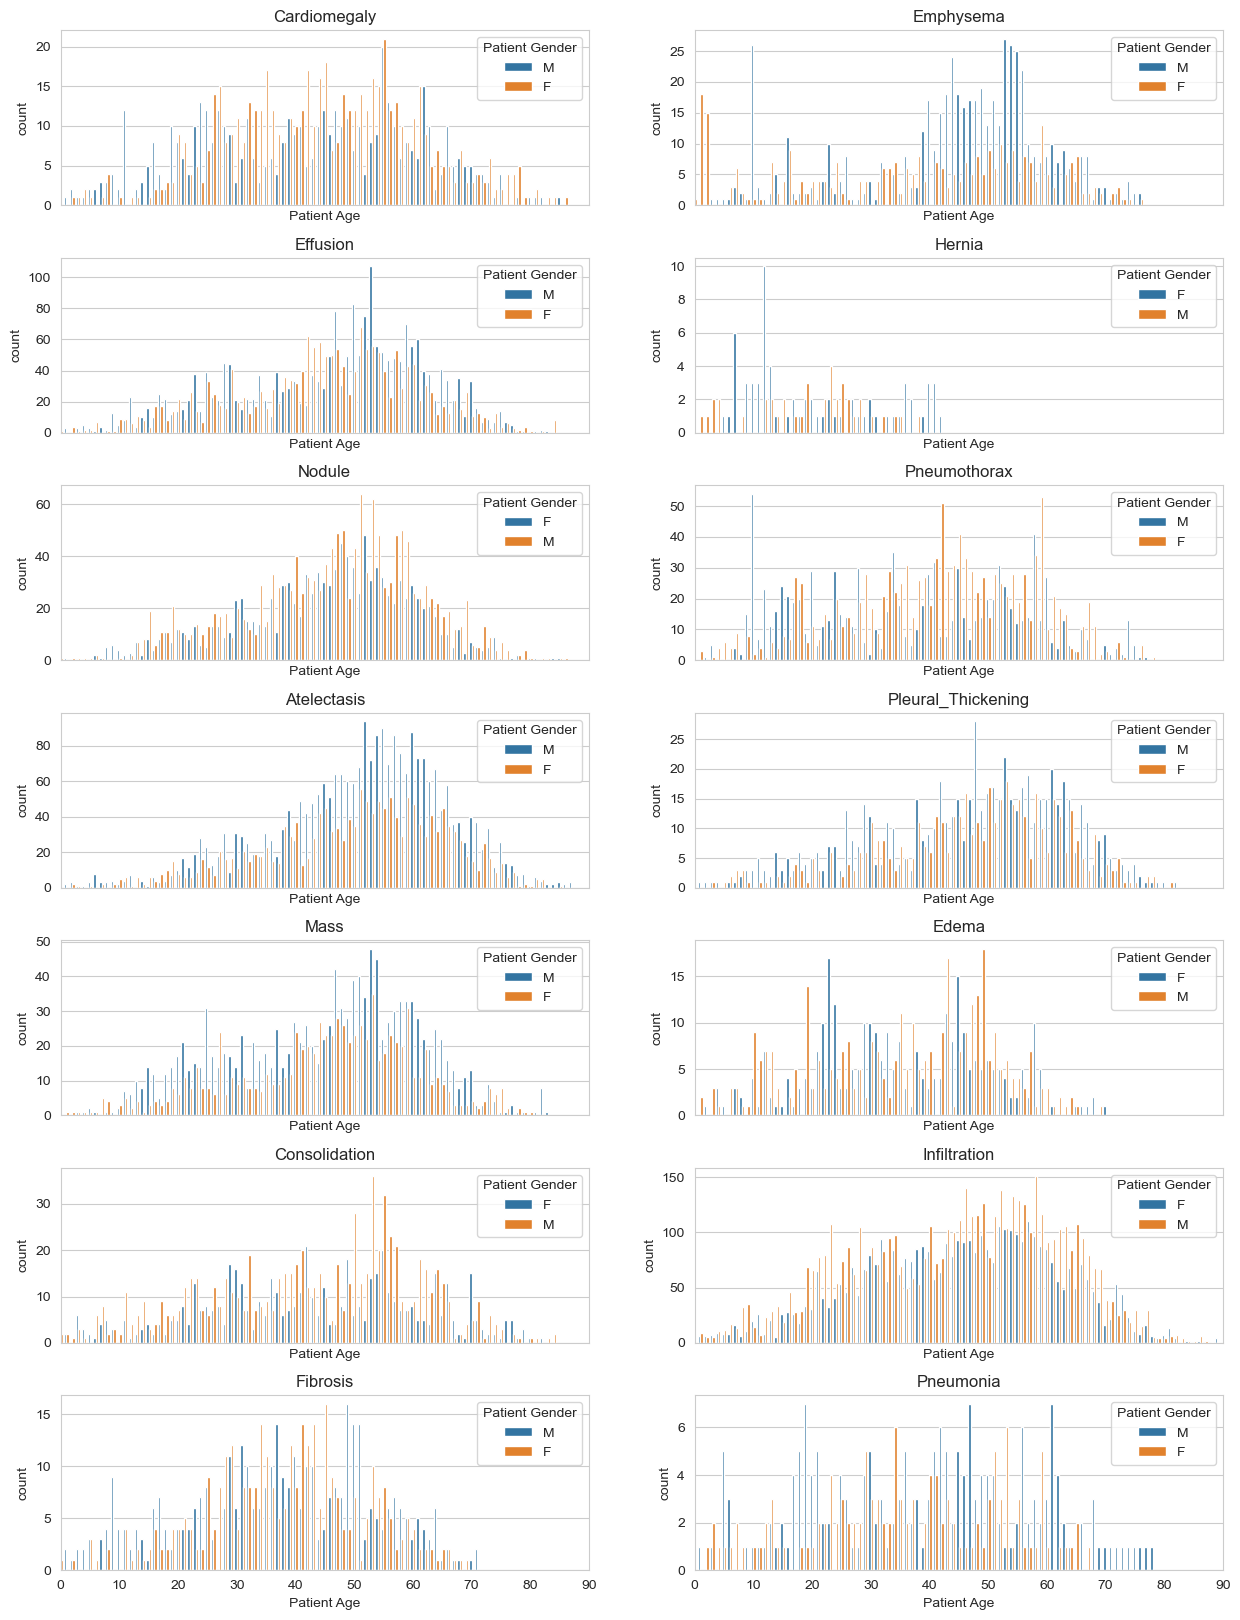

In [62]:
f, axarr = plt.subplots(7, 2, sharex=True,figsize=(15, 20))

i=0
j=0
x=np.arange(0,100,10)
for pathology in pathology_list :
    g=sns.countplot(x='Patient Age', hue="Patient Gender",data=data[data['Finding Labels']==pathology], ax=axarr[i, j])
    axarr[i, j].set_title(pathology)   
    g.set_xlim(0,90)
    g.set_xticks(x)
    g.set_xticklabels(x)
    j=(j+1)%2
    if j==0:
        i=(i+1)%7
f.subplots_adjust(hspace=0.3)

In [63]:
data=data.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=data[['|' in index for index in data.index]].copy()
df2=data[['|' not in index for index in data.index]]
df2=df2[['No Finding' not in index for index in df2.index]]
df2['Finding Labels']=df2.index.values
df1['Finding Labels']=df1.index.values

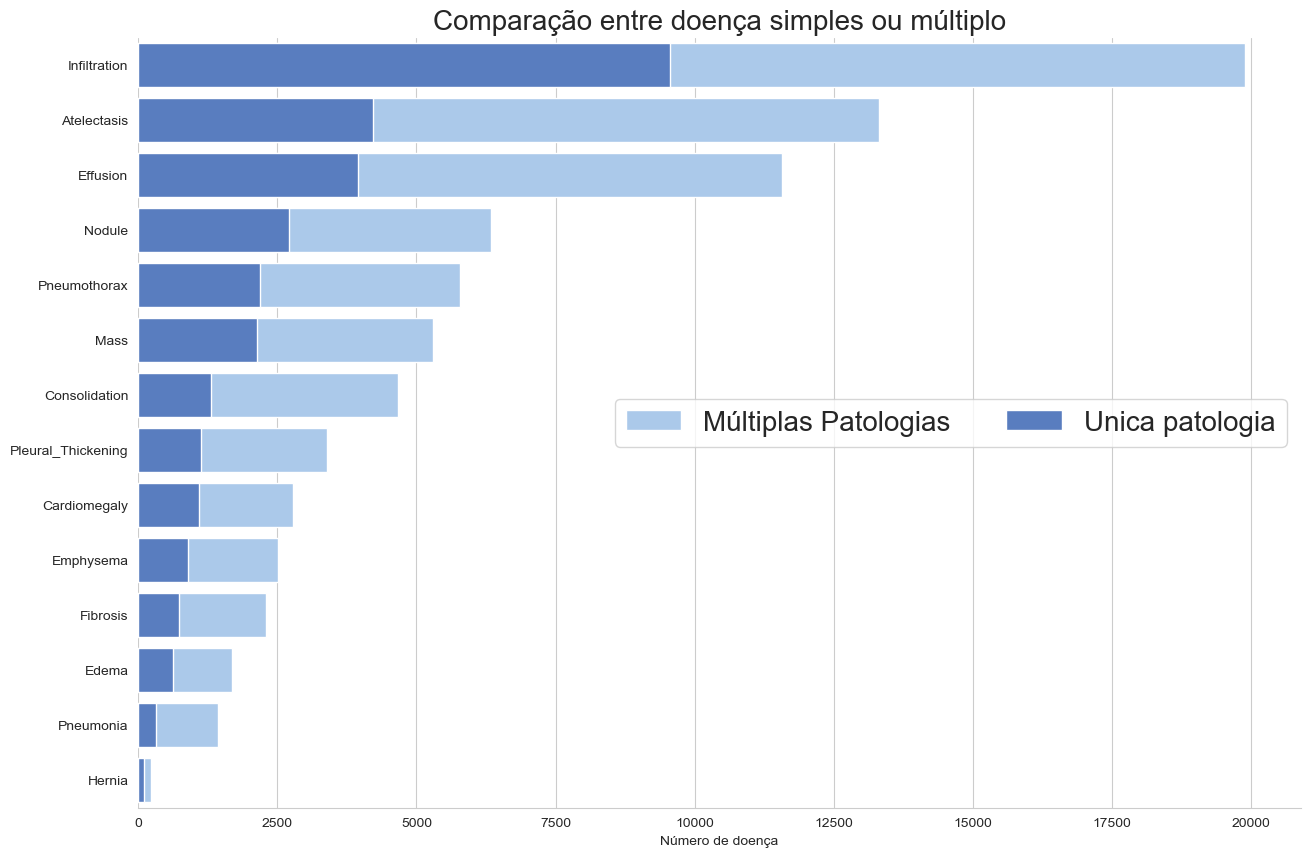

In [65]:
f, ax = plt.subplots(sharex=True,figsize=(15, 10))
sns.set_color_codes("pastel")
g=sns.countplot(y='Category',data=data1, ax=ax, order = data1['Category'].value_counts().index,color='b',label="Múltiplas Patologias")
sns.set_color_codes("muted")
g=sns.barplot(x='Patient ID',y='Finding Labels',data=df2, ax=ax, color="b",label="Unica patologia")
ax.legend(ncol=2, loc="center right", frameon=True,fontsize=20)
ax.set( ylabel="",xlabel="Número de doença")
ax.set_title("Comparação entre doença simples ou múltiplo",fontsize=20)      
sns.despine(left=True)

In [67]:
df3=df1.loc[df1['Patient ID']>30,['Patient ID','Finding Labels']]

for pathology in pathology_list:
    df3[pathology]=df3.apply(lambda x: x['Patient ID'] if pathology in x['Finding Labels'] else 0, axis=1)

df3.head(20)

,Patient ID,Finding Labels,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia
Finding Labels,,,,,,,,,,,,,,,,
Effusion|Infiltration,1603,Effusion|Infiltration,0,0,1603,0,0,0,0,0,0,0,0,1603,0,0
Atelectasis|Infiltration,1350,Atelectasis|Infiltration,0,0,0,0,0,0,1350,0,0,0,0,1350,0,0
Atelectasis|Effusion,1165,Atelectasis|Effusion,0,0,1165,0,0,0,1165,0,0,0,0,0,0,0
Infiltration|Nodule,829,Infiltration|Nodule,0,0,0,0,829,0,0,0,0,0,0,829,0,0
Atelectasis|Effusion|Infiltration,737,Atelectasis|Effusion|Infiltration,0,0,737,0,0,0,737,0,0,0,0,737,0,0
Cardiomegaly|Effusion,484,Cardiomegaly|Effusion,484,0,484,0,0,0,0,0,0,0,0,0,0,0
Consolidation|Infiltration,441,Consolidation|Infiltration,0,0,0,0,0,0,0,0,0,0,441,441,0,0
Infiltration|Mass,420,Infiltration|Mass,0,0,0,0,0,0,0,0,420,0,0,420,0,0
Effusion|Pneumothorax,403,Effusion|Pneumothorax,0,0,403,0,0,403,0,0,0,0,0,0,0,0


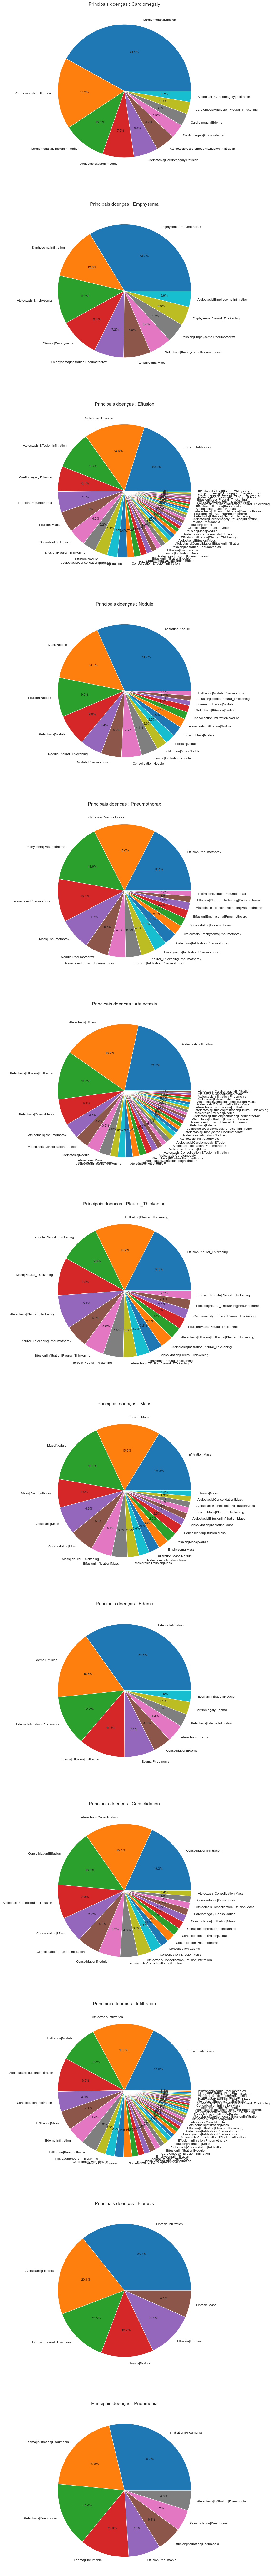

In [68]:
df4=df3[df3['Hernia']>0] 
pat_list=[elem for elem in pathology_list if 'Hernia' not in elem]

f, axarr = plt.subplots(13, sharex=True,figsize=(10, 140))
i=0
for pathology in pat_list :
    df4=df3[df3[pathology]>0]
    if df4.size>0:  #'Hernia' has not enough values to figure here
        axarr[i].pie(df4[pathology],labels=df4['Finding Labels'], autopct='%1.1f%%')
        axarr[i].set_title('Principais doenças : '+pathology,fontsize=14)   
        i +=1